# What this code does: Top genes selection--> Impute --> Clustering
#  Imputation methods included: MAGIC, KNN, Soft impute, Simple immpute (You can add more imputation methods in the 'Imputation Evaluator Class easily....)
1. Gene Selection Criteria: All genes, top 2000 genes, top 5000 genes
2. Leiden Clustering is used when inferencing.

The code can be run in three mode:
1) Full Batch Mode: It will look into a directory for '.h5ad' file and run them one by one for all genes, top 2000 genes, top 5000 genes and then save in a csv.
2) Semi Batch Mode: It will look into a directory for '.h5ad' file and an external parameter can be set which will decide how many datasets will be processed at once for all genes, top 2000 genes and top 5000 genes.
3) Multi-batch mode: It will look into a directory for '.h5ad' file and two external parameters can be set where first parameter will decide how many datasets will be processed at once and second parameter will decide the number of gene selection value from all genes, top 2000 genes and top 5000 genes to be processed for each datasets.

Such modes are created for easier usability as different computer configuration can take longer time if all of the run at once!

In [ ]:
# @title mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title installing packages
!pip install scanpy
!pip install magic-impute
!pip install igraph
!pip3 install leidenalg
!pip install fancyimpute
!pip install -U scvi-tools
!pip install tangram-sc

In [ ]:
# @title Importing packages

# System & utility
import os
import time
import psutil
import tracemalloc
from tqdm import tqdm

# Core scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning and preprocessing
from sklearn import metrics
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    normalized_mutual_info_score,
    adjusted_rand_score,
    adjusted_mutual_info_score,
    homogeneity_score
)

# Matrix and sparse operations
from scipy import sparse
from scipy.sparse import issparse, csr_matrix
from scipy.sparse.linalg import svds

# Imputation methods
import magic
from fancyimpute import SoftImpute

# Single-cell packages
import scanpy as sc
from scvi.external import GIMVI
import tangram as tg
import scvi

# Uncomment these if needed later
# import scarches as sca
# import dca


In [2]:
# @title Imputation Evaluator

class ImputationEvaluator:
    def __init__(self, dataset_path, n_top_genes=2000):
        self.dataset_path = dataset_path
        self.dataset_name = os.path.basename(dataset_path)

        if n_top_genes == 'all':
            self.n_top_genes = None
        else:
            self.n_top_genes = int(n_top_genes)

        self.load_data()

    def load_data(self):
        """Load dataset and select top highly variable genes."""
        print(f"\nLoading dataset: {self.dataset_path}")
        self.adata = sc.read_h5ad(self.dataset_path)

        # Convert sparse matrix to dense if necessary
        # self.adata = self.adata.copy()
        X = self.adata.X
        if issparse(X):
            X = X.toarray()
            self.adata.X = X


        print(f"In the Imputation Evaluator the n_top_genes: {self.n_top_genes}\n\n")
        print(f"Original adata shape: {self.adata.shape}")

        # Determine ground truth label key
        if 'annotation' in self.adata.obs.columns:
            self.annotation_key = 'annotation'
        elif 'CellType' in self.adata.obs.columns:
            self.annotation_key = 'CellType'
        else:
            raise ValueError(f"No 'annotation' or 'CellType' found in obs columns for {self.dataset_name}")

        self.size_after_preprocessing = self.adata.shape

        if self.n_top_genes is not None:
          print(f"top genes the class got: {self.n_top_genes}\n")
          print(f"type of this var: {type(self.n_top_genes)}\n")
          # Keep the top highly variable genes
          sc.pp.highly_variable_genes(self.adata, flavor="seurat", n_top_genes=self.n_top_genes)
          self.adata = self.adata[:, self.adata.var['highly_variable']]
          self.size_after_top_genes = self.adata.shape
          print(f"Adata shape after selecting top {self.n_top_genes} genes: {self.adata.shape}")
        else:
          self.size_after_top_genes = self.adata.shape

    @staticmethod
    def calculate_sparsity(X):
        """Calculate sparsity of a matrix."""
        if issparse(X):
            X = X.toarray()
        zero_elements = np.sum(X == 0)
        total_elements = X.size
        return 100.0 * float(zero_elements) / float(total_elements)


    @staticmethod
    def magic_impute(X):
        """Apply MAGIC imputation."""
        return magic.MAGIC().fit_transform(X)

    @staticmethod
    def knn_impute(X, k=5):
        """Apply KNN imputation."""
        imputer = KNNImputer(n_neighbors=k)
        return imputer.fit_transform(X)
    
    
    @staticmethod
    def soft_impute(X, max_rank=50, max_iters=100, init_fill_method="mean", verbose=False):
        """Apply Soft Impute imputation."""
        """
        SoftImpute for matrix completion.

        Parameters:
        - X: Input expression matrix (NumPy array) with zeros as missing values.
        - max_rank: Maximum rank constraint.
        - max_iters: Maximum number of iterations.
        - init_fill_method: How to fill missing values initially ("zero", "mean", etc.)

        Returns:
        - Imputed matrix
        """
        X[X == 0] = np.nan  # SoftImpute expects np.nan as missing entries

        imputer = SoftImpute(
            max_rank=max_rank,
            max_iters=max_iters,
            init_fill_method=init_fill_method,
            verbose=verbose
        )
        X_imputed = imputer.fit_transform(X)
        return X_imputed

    @staticmethod
    def simpleimpute(X):
        """Apply SimpleImputer imputation."""
        X[X == 0] = np.nan
        imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
        imp_mean.fit(X)
        X_imputed = imp_mean.transform(X)
        return X_imputed

    """............More imputation
    methods to add...................."""
    # def dummy_imputation_X(X):
    #     """Dummy imputation method X (for placeholder)."""
    #     return X + np.random.normal(0, 0.01, size=X.shape)


    # def dummy_imputation_Y(X):
    #     """Dummy imputation method Y (for placeholder)."""
    #     return np.clip(X * 1.01, 0, None)

    def perform_clustering(self, adata, cluster_key):
        """Perform PCA, neighbors, UMAP and Leiden clustering."""
        sc.pp.pca(adata)
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)
        sc.tl.leiden(adata, key_added=cluster_key, directed=False, n_iterations=2)

    def perform_clustering_with_plot(self, adata, cluster_key, dataset_name=None, n_top_genes=2000, spot_size=2.5):
        """Perform PCA, neighbors, UMAP, Leiden clustering, and plot UMAP."""

        # Step 1: Dimensionality reduction and clustering
        sc.pp.pca(adata)
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)
        sc.tl.leiden(adata, key_added=cluster_key, directed=False, n_iterations=2)

        # Step 2: Title for UMAP plot
        if n_top_genes is not None:
            title = f"UMAP - {dataset_name} | Top {n_top_genes} genes" if dataset_name and n_top_genes else "UMAP"
        else:
            title = f"UMAP - {dataset_name} | Full Data" if dataset_name else "UMAP"

        adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")
        # Step 3: Show UMAP plot
        sc.pl.umap(
            adata,
            color=cluster_key,
            title=title,
            legend_loc='on data',
            frameon=False,
            show=True
        )

        # Commented out for xyz as spatial info not available for xyzeq...
        # Step 4: Title for predicted label on the sptial plot
        # if n_top_genes is not None:
        #     title = f"Predicted Spatial Plot - {dataset_name} | Top {n_top_genes} genes" if dataset_name and n_top_genes else "Predicted Spatial Plot"
        # else:
        #     title = f"Predicted Spatial Plot - {dataset_name} | Full Data" if dataset_name else "Predicted Spatial Plot"
        # # Step 5: Show predicted spatial plot

        # # Convert to string first if it's not already (to avoid issues with int vs str)
        # adata.obs[cluster_key] = adata.obs[cluster_key].astype(str)

        # # Then make it a categorical
        # adata.obs[cluster_key] = pd.Categorical(adata.obs[cluster_key])

        # sc.pl.spatial(
        #     adata,
        #     color=cluster_key,
        #     title=title,
        #     spot_size=spot_size
        # )

    def plot_spatial_with_predicted_labels(self, adata, annotation_key='annotation', dataset_name=None, s=4, n_top_genes=2000):
        """
        Plots 2D spatial coordinates of cells colored by true labels.

        Parameters:
        - adata: AnnData object with adata.obsm['spatial'] and adata.obs[annotation_key]
        - annotation_key: Column in adata.obs for true labels (e.g., 'annotation', 'cell_type')
        - dataset_name: Optional dataset name for the plot title
        - s: Marker size
        """

        # Step 1: Get spatial coordinates
        spatial_coords = adata.obsm['spatial']
        x = spatial_coords[:, 0]
        y = spatial_coords[:, 1]

        # Step 2: Prepare labels
        labels = adata.obs[self.annotation_key]
        if labels.dtype.name == 'category' or labels.dtype == object:
            le = LabelEncoder()
            color_labels = le.fit_transform(labels)
            label_names = le.classes_
        else:
            color_labels = labels
            label_names = np.unique(labels)

        # Step 3: Plot
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(x, y, c=color_labels, cmap='tab20', s=s, alpha=0.8)
        plt.gca().invert_yaxis()  # Optional: if spatial coordinates are top-down
        plt.title(f"Spatial Plot (Predicted Labels) - {dataset_name}|{n_top_genes} top genes" if dataset_name else "Spatial Plot (Predicted Labels)")
        plt.xlabel("Spatial 1")
        plt.ylabel("Spatial 2")

        # Create legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                            markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=8)
                for i, label in enumerate(label_names)]
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()

    def plot_spatial_with_true_labels(self, adata, annotation_key='annotation', dataset_name=None, spot_size=2.5):
        """
        Plots spatial coordinates of cells using scanpy's built-in spatial plot,
        colored by true labels (e.g., cell types).

        Parameters:
        - adata: AnnData object with adata.obsm['spatial'] and adata.obs[annotation_key]
        - annotation_key: Column in adata.obs for true labels (e.g., 'annotation', 'cell_type')
        - dataset_name: Optional dataset name for title
        - spot_size: Marker size for plotting
        """
        if annotation_key not in adata.obs:
            raise ValueError(f"'{annotation_key}' not found in adata.obs")

        
        sc.pl.spatial(
            adata,
            color=annotation_key,
            title=f"Spatial Plot - {dataset_name}" if dataset_name else "Spatial Plot (True Labels)",
            spot_size=spot_size
        )


    def evaluate_clustering(self, adata, cluster_key):
        """Compute ARI, NMI, AMI, and Homogeneity scores."""
        true_labels = adata.obs[self.annotation_key]
        predicted_labels = adata.obs[cluster_key]

        ari = adjusted_rand_score(true_labels, predicted_labels)
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        ami = adjusted_mutual_info_score(true_labels, predicted_labels)
        homo = homogeneity_score(true_labels, predicted_labels)

        return ari, nmi, ami, homo

    def run_full_evaluation(self):
        """
        Run baseline clustering and multiple imputations.
        Returns: dict with all results
        """
        results = {}

        # Define available imputations
        imputation_methods = {
            'magic': self.magic_impute,
            'knn': self.knn_impute,
            'softimpute': self.soft_impute,
            'simpleimpute': self.simpleimpute
        }
        # imputation_methods = {
        #     'magic': self.magic_impute,
        #     'alra': self.alra_impute,
        #     'dummy_X': self.dummy_imputation_X,
        #     'dummy_Y': self.dummy_imputation_Y,
        # }

        # Calculate initial sparsity
    
        results['Raw zero Exp val (%)'] = self.calculate_sparsity(self.adata.X)

        # True Labels plot
        # print(f"True Labels plot for the dataset {self.dataset_name}..\n")
        # self.plot_spatial_with_true_labels(self.adata, dataset_name=self.dataset_name)
        # Baseline clustering
        print("performing baseline clustering..\n")
        ari_scores, nmi_scores, ami_scores, homo_scores = [], [], [], []

        for i in range(5):
            print(f"Base Clustering Run {i+1}...")
            # self.perform_clustering(self.adata, cluster_key="clusters_original")
            self.perform_clustering_with_plot(self.adata, cluster_key="clusters_original", dataset_name=self.dataset_name, n_top_genes=self.n_top_genes)
            ari, nmi, ami, homo = self.evaluate_clustering(self.adata, "clusters_original")

            ari_scores.append(ari)
            nmi_scores.append(nmi)
            ami_scores.append(ami)
            homo_scores.append(homo)

        # Compute mean values across the 5 runs
        base_ari = np.mean(ari_scores)
        base_nmi = np.mean(nmi_scores)
        base_ami = np.mean(ami_scores)
        base_homo = np.mean(homo_scores)

        results.update({
            'Base ARI': base_ari,
            'Base NMI': base_nmi,
            'Base AMI': base_ami,
            'Base HOMO': base_homo,
        })

        # Perform imputations
        for method_name, imputation_function in tqdm(imputation_methods.items(), desc="Running Imputations", leave=False):
            adata_imputed = self.adata.copy()

            X = adata_imputed.X
            if issparse(X):
                X = X.toarray()
                adata_imputed.X = X

            tracemalloc.start()
            start_time = time.time()

            # Apply imputation
            adata_imputed.X = imputation_function(adata_imputed.X)

            end_time = time.time()
            current, peak = tracemalloc.get_traced_memory()
            runtime = end_time - start_time
            memory = peak / (1024 ** 2)  # MB
            tracemalloc.stop()

            # Clustering after imputation
            cluster_key = f"clusters_{method_name}"
            print(f"performing clustering on the {method_name} imputation..\n")

            ari_scores, nmi_scores, ami_scores, homo_scores = [], [], [], []

            for i in range(5):
              print(f"Clustering Run {i+1}...")
              # self.perform_clustering(adata_imputed, cluster_key=cluster_key)
              self.perform_clustering_with_plot(adata_imputed, cluster_key=cluster_key, dataset_name=self.dataset_name, n_top_genes=self.n_top_genes)
            #   self.plot_spatial_with_predicted_labels(adata_imputed, annotation_key=cluster_key, dataset_name=self.dataset_name, n_top_genes=self.n_top_genes)
              ari, nmi, ami, homo = self.evaluate_clustering(adata_imputed, cluster_key)

              ari_scores.append(ari)
              nmi_scores.append(nmi)
              ami_scores.append(ami)
              homo_scores.append(homo)

            # Compute mean values across the 5 runs
            ari = np.mean(ari_scores)
            nmi = np.mean(nmi_scores)
            ami = np.mean(ami_scores)
            homo = np.mean(homo_scores)

            # Save results
            results.update({
                f'ARI_{method_name}': ari,
                f'NMI_{method_name}': nmi,
                f'AMI_{method_name}': ami,
                f'HOMO_{method_name}': homo,
                f'{method_name} zero Exp val (%)': self.calculate_sparsity(adata_imputed.X),
                f'{method_name} Runtime (s)': runtime,
                f'{method_name} Memory (MB)': memory,
            })

        return results


In [3]:
# @title run_on_multiple_datasets

def run_on_multiple_datasets(folder_path, n_top_genes=2000):
    """Run evaluation on all datasets and save results to CSV."""
    datasets = [f for f in os.listdir(folder_path) if f.endswith('.h5ad')]
    all_results = []

    for dataset_name in tqdm(datasets, desc="Datasets"):
        dataset_path = os.path.join(folder_path, dataset_name)
        evaluator = ImputationEvaluator(dataset_path, n_top_genes)

        results = evaluator.run_full_evaluation()
        result_row = {
            'Dataset Name': evaluator.dataset_name,
            'Size After pre-processing': f"{evaluator.size_after_preprocessing[0]}x{evaluator.size_after_preprocessing[1]}",
            'Size After selecting top genes': f"{evaluator.size_after_top_genes[0]}x{evaluator.size_after_top_genes[1]}",
            'Base ARI': results['Base ARI'],
            'Base NMI': results['Base NMI'],
            'Base AMI': results['Base AMI'],
            'Base HOMO': results['Base HOMO'],
            'Raw zero Exp val (%)': results['Raw zero Exp val (%)'],
            'Cluster Algo': 'Leiden',
            'top_genes': n_top_genes
        }

        # Add all imputation-specific results dynamically
        for key, value in results.items():
            if key not in result_row:
                result_row[key] = value

        all_results.append(result_row)

    # convert the results to a dataframe
    df_results = pd.DataFrame(all_results)

    return df_results

In [4]:
# @title run_on_single_dataset

def run_on_single_dataset(dataset_path, n_top_genes):
    """Process a single dataset, evaluate, and append results to CSV."""

    evaluator = ImputationEvaluator(dataset_path, n_top_genes)
    results = evaluator.run_full_evaluation()

    result_row = {
        'Dataset Name': evaluator.dataset_name,
        'Size After pre-processing': f"{evaluator.size_after_preprocessing[0]}x{evaluator.size_after_preprocessing[1]}",
        'Size After selecting top genes': f"{evaluator.size_after_top_genes[0]}x{evaluator.size_after_top_genes[1]}",
        'Base ARI': results['Base ARI'],
        'Base NMI': results['Base NMI'],
        'Base AMI': results['Base AMI'],
        'Base HOMO': results['Base HOMO'],
        'Raw zero Exp val (%)': results['Raw zero Exp val (%)'],
        'Cluster Algo': 'Leiden',
        'top_genes': n_top_genes
    }

    # Add dynamic imputation-specific results
    for key, value in results.items():
        if key not in result_row:
            result_row[key] = value

    # Convert to DataFrame
    df_row = pd.DataFrame([result_row])

    return df_row



In [5]:
# @title post processing after evaluating imputations

def reorder_columns(df):
  # Define the base columns
  base_keys = ['Dataset Name', 'Size After pre-processing', 'Size After selecting top genes', 'Cluster Algo', 'top_genes']

  # Dynamically collect other metric-type columns
  ari_keys = [col for col in df.columns if 'ARI' in col]
  nmi_keys = [col for col in df.columns if 'NMI' in col]
  ami_keys = [col for col in df.columns if 'AMI' in col]
  homo_keys = [col for col in df.columns if 'HOMO' in col]
  zero_keys = [col for col in df.columns if 'zero' in col]
  runtime_keys = [col for col in df.columns if 'Runtime' in col]
  memory_keys = [col for col in df.columns if 'Memory' in col]

  # Catch any columns not included above
  all_collected = set(base_keys + ari_keys + nmi_keys + ami_keys + homo_keys + zero_keys + runtime_keys + memory_keys)
  remaining_keys = [col for col in df.columns if col not in all_collected]

  # Reorder the DataFrame
  ordered_cols = base_keys + ari_keys + nmi_keys + ami_keys + homo_keys + zero_keys + runtime_keys + memory_keys + remaining_keys
  df = df[ordered_cols]

  return df



In [ ]:
# @title main function to run Full Batch Mode

if __name__ == "__main__":
  dataset_path = 'D:/VM Data/thesis/Analysis/visium/'
  n_top = ['all', 2000, 5000]
  # List to collect DataFrames
  all_results = []
  output_csv = f"visium_magic_knn_soft_simple_imputation_results.csv"

  for n in n_top:
    # Run the function
    df_results = run_on_multiple_datasets(dataset_path, n_top_genes = n)
    # Collect in list
    all_results.append(df_results)

  # Merge all DataFrames
  final_df = pd.concat(all_results, ignore_index=True)

  # Sort by Dataset name, then by Top_Genes value
  final_df = final_df.sort_values(by=["Dataset Name", "top_genes"]).reset_index(drop=True)

  # reorder the results
  df_results_reordered = reorder_columns(final_df)

  # save to csv
  output_path = os.path.join(dataset_path, output_csv)
  df_results_reordered.to_csv(output_path, index=False)
  print(f"\nAll results saved to {output_path}")



Datasets:   0%|          | 0/3 [00:00<?, ?it/s]


Loading dataset: /content/drive/MyDrive/UIU/MSCSE/Thesis/05. Codes and Datasets/ST_datasets/stereo-seq/DX6_D2_stereo-seq_processed.h5ad
Original adata shape: (14852, 19430)
Adata shape after selecting top 2000 genes: (14852, 2000)
performing baseline clustering..


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca
<ipython-input-4-f3ce46c4d68c>:74: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=cluster_key, directed=False, n_iterations=2)

Running Imputations:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating MAGIC...
  Running MAGIC on 14852 cells and 2000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 6.28 seconds.
    Calculating KNN search...
    Calculated KNN search in 70.81 seconds.
    Calculating affinities...
    Calculated affinities in 78.50 seconds.
  Calculated graph and diffusion operator in 155.66 seconds.
  Calculating imputation...
  Calculated imputation in 5.84 seconds.
Calculated MAGIC in 161.54 seconds.
performing clustering on the magic imputation..



Running Imputations:  50%|█████     | 1/2 [03:13<03:13, 193.70s/it]

performing clustering on the alra imputation..



Datasets:  33%|███▎      | 1/3 [06:02<12:04, 362.40s/it]


Loading dataset: /content/drive/MyDrive/UIU/MSCSE/Thesis/05. Codes and Datasets/ST_datasets/stereo-seq/FB2_D1_stereo-seq_processed.h5ad
Original adata shape: (16263, 19639)
Adata shape after selecting top 2000 genes: (16263, 2000)
performing baseline clustering..


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca

Running Imputations:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating MAGIC...
  Running MAGIC on 16263 cells and 2000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 5.08 seconds.
    Calculating KNN search...
    Calculated KNN search in 91.81 seconds.
    Calculating affinities...
    Calculated affinities in 88.98 seconds.
  Calculated graph and diffusion operator in 185.93 seconds.
  Calculating imputation...
  Calculated imputation in 4.29 seconds.
Calculated MAGIC in 190.25 seconds.
performing clustering on the magic imputation..



Running Imputations:  50%|█████     | 1/2 [03:46<03:46, 226.45s/it]

performing clustering on the alra imputation..



Datasets:  67%|██████▋   | 2/3 [11:28<05:40, 340.95s/it]


Loading dataset: /content/drive/MyDrive/UIU/MSCSE/Thesis/05. Codes and Datasets/ST_datasets/stereo-seq/DT2_D0_stereo-seq_processed.h5ad
Original adata shape: (42658, 20735)
Adata shape after selecting top 2000 genes: (42658, 2000)
performing baseline clustering..


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca

Running Imputations:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating MAGIC...
  Running MAGIC on 42658 cells and 2000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 11.76 seconds.
    Calculating KNN search...
    Calculated KNN search in 659.81 seconds.
    Calculating affinities...
    Calculated affinities in 644.80 seconds.
  Calculated graph and diffusion operator in 1316.50 seconds.
  Calculating imputation...
  Calculated imputation in 16.35 seconds.
Calculated MAGIC in 1332.90 seconds.
performing clustering on the magic imputation..



Running Imputations:  50%|█████     | 1/2 [23:50<23:50, 1430.20s/it]

performing clustering on the alra imputation..



Datasets:   0%|          | 0/3 [00:00<?, ?it/s]


Loading dataset: /content/drive/MyDrive/UIU/MSCSE/Thesis/05. Codes and Datasets/ST_datasets/stereo-seq/DX6_D2_stereo-seq_processed.h5ad
Original adata shape: (14852, 19430)
Adata shape after selecting top 5000 genes: (14852, 5000)
performing baseline clustering..


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca

Running Imputations:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating MAGIC...
  Running MAGIC on 14852 cells and 5000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 10.05 seconds.
    Calculating KNN search...
    Calculated KNN search in 67.46 seconds.
    Calculating affinities...
    Calculated affinities in 73.76 seconds.
  Calculated graph and diffusion operator in 151.32 seconds.
  Calculating imputation...
  Calculated imputation in 13.62 seconds.
Calculated MAGIC in 164.98 seconds.
performing clustering on the magic imputation..



Running Imputations:  50%|█████     | 1/2 [03:38<03:38, 218.80s/it]

performing clustering on the alra imputation..



Datasets:  33%|███▎      | 1/3 [05:38<11:17, 338.64s/it]


Loading dataset: /content/drive/MyDrive/UIU/MSCSE/Thesis/05. Codes and Datasets/ST_datasets/stereo-seq/FB2_D1_stereo-seq_processed.h5ad
Original adata shape: (16263, 19639)
Adata shape after selecting top 5000 genes: (16263, 5000)
performing baseline clustering..


/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_pca/__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca

Running Imputations:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating MAGIC...
  Running MAGIC on 16263 cells and 5000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 9.16 seconds.
    Calculating KNN search...
    Calculated KNN search in 90.05 seconds.
    Calculating affinities...
    Calculated affinities in 88.80 seconds.
  Calculated graph and diffusion operator in 188.08 seconds.
  Calculating imputation...
  Calculated imputation in 10.65 seconds.
Calculated MAGIC in 198.79 seconds.
performing clustering on the magic imputation..



Running Imputations:  50%|█████     | 1/2 [04:17<04:17, 257.48s/it]

performing clustering on the alra imputation..



Datasets:  67%|██████▋   | 2/3 [12:04<06:06, 366.42s/it]


Loading dataset: /content/drive/MyDrive/UIU/MSCSE/Thesis/05. Codes and Datasets/ST_datasets/stereo-seq/DT2_D0_stereo-seq_processed.h5ad
Original adata shape: (42658, 20735)


In [ ]:
# @title main function to run in Semi Batch Mode



if __name__ == "__main__":

    dataset_folder = 'D:/VM Data/thesis/Analysis/slideseq/'
    output_csv = os.path.join(dataset_folder, "visium_magic_knn_soft_simple_imputation_results.csv")
    n_top = ['all', 2000, 5000]
    # n_top = ['all']

    batch_size = 1  # Change this to control how many datasets to process per run
    # n_top_batch_size = 1

    # Get all .h5ad dataset filenames
    all_datasets = sorted([f for f in os.listdir(dataset_folder) if f.endswith('.h5ad')])

    # Get names of already processed datasets from the CSV
    if os.path.exists(output_csv):
        df_done = pd.read_csv(output_csv)
        processed_datasets = set(df_done['Dataset Name'].unique())
        print(processed_datasets)
    else:
        processed_datasets = set()

    # Find remaining datasets to process
    remaining_datasets = [f for f in all_datasets if f not in processed_datasets]
    print(remaining_datasets)

    if not remaining_datasets:
        print("✅ All datasets are already processed and saved in the CSV.\n")
    else:
        print(f"🟡 Found {len(remaining_datasets)} remaining datasets.\n")
        to_process = remaining_datasets[:batch_size]

        for dataset_filename in tqdm(to_process, desc="Processing Datasets in Bath-mode"):
            dataset_path = os.path.join(dataset_folder, dataset_filename)
            all_results = []

            for n in n_top:
              print(f"Analyzing dataset {dataset_filename} for top genes {n}\n")
              df_row = run_on_single_dataset(dataset_path, n_top_genes=n)
              all_results.append(df_row)
            print(f"✔ Analyzing finished for {dataset_filename}\n")
            print(f"save the results for the dataset {dataset_filename} in the csv\n")

            # Merge all DataFrames
            final_df = pd.concat(all_results, ignore_index=True)

            # Sort by Dataset name, then by Top_Genes value
            final_df = final_df.sort_values(by=["Dataset Name", "top_genes"]).reset_index(drop=True)

            # reorder the results
            df_results_reordered = reorder_columns(final_df)

            # Append to CSV
            if os.path.exists(output_csv):
                df_results_reordered.to_csv(output_csv, mode='a', header=False, index=False)
            else:
                df_results_reordered.to_csv(output_csv, index=False)

            print(f"Results saved for the dataset {dataset_filename} in the csv!!\n")



🟡 1 datasets still need processing:
  🔸 GSM5009539_XYZeq_raw_processed_updated.h5ad: Missing top_genes → ['all', '2000', '5000']



Processing Datasets in Batch-mode:   0%|          | 0/1 [00:00<?, ?it/s]

🔍 Analyzing dataset GSM5009539_XYZeq_raw_processed_updated.h5ad for top genes all

Loading dataset: D:/VM Data/thesis/Analysis/xyzeq/GSM5009539_XYZeq_raw_processed_updated.h5ad
In the Imputation Evaluator the n_top_genes: None


Original adata shape: (1121, 9421)
performing baseline clustering..

Base Clustering Run 1...


C:\Users\fahim\AppData\Local\Temp\ipykernel_23268\3761332667.py:134: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=cluster_key, directed=False, n_iterations=2)


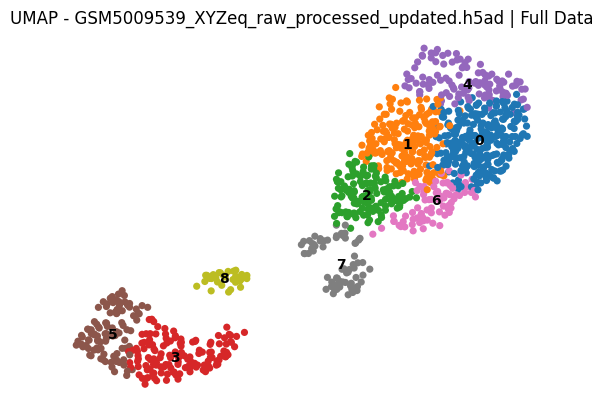

Base Clustering Run 2...


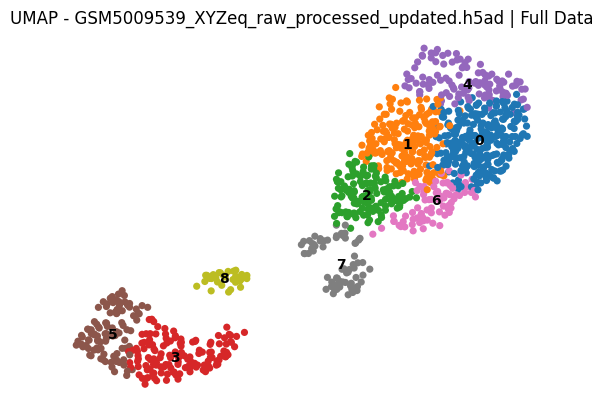

Base Clustering Run 3...


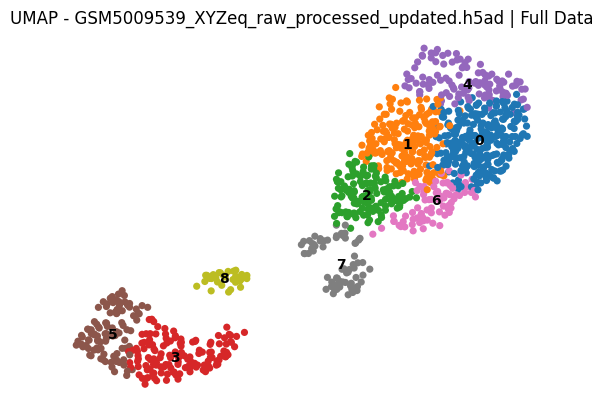

Base Clustering Run 4...


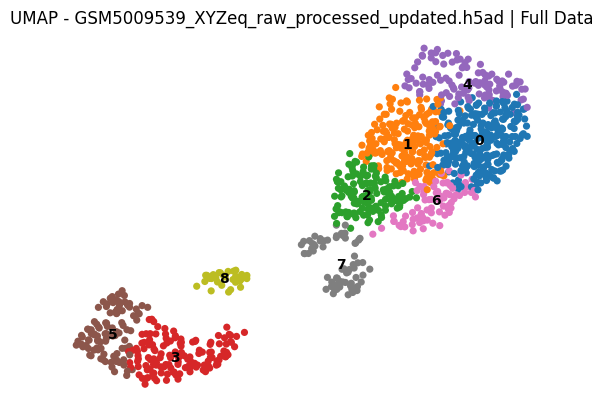

Base Clustering Run 5...


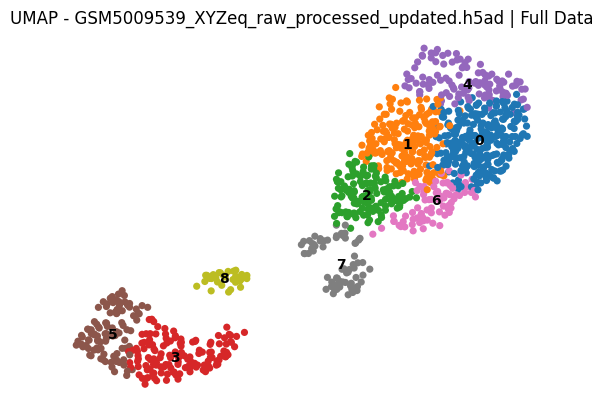

Calculating MAGIC...
  Running MAGIC on 1121 cells and 9421 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 0.81 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.12 seconds.
    Calculating affinities...
    Calculated affinities in 0.12 seconds.
  Calculated graph and diffusion operator in 1.06 seconds.
  Running MAGIC with `solver='exact'` on 9421-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 0.29 seconds.
Calculated MAGIC in 1.37 seconds.
performing clustering on the magic imputation..

Clustering Run 1...


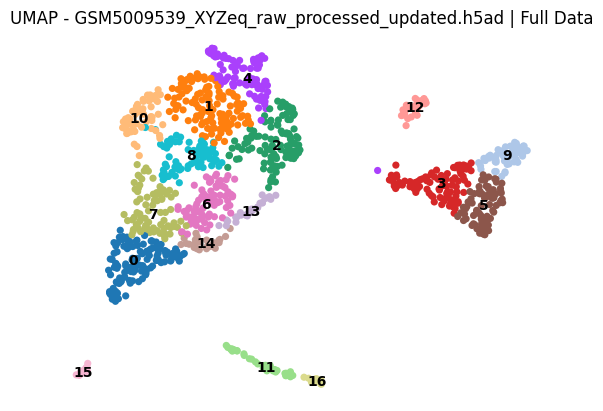

Clustering Run 2...


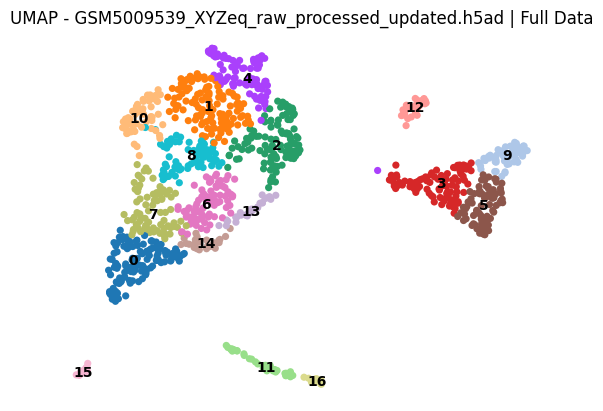

Clustering Run 3...


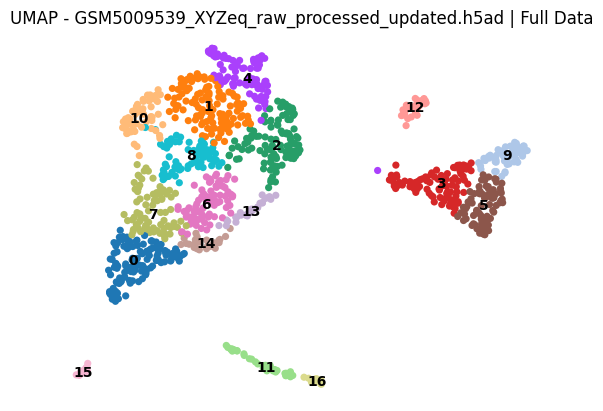

Clustering Run 4...


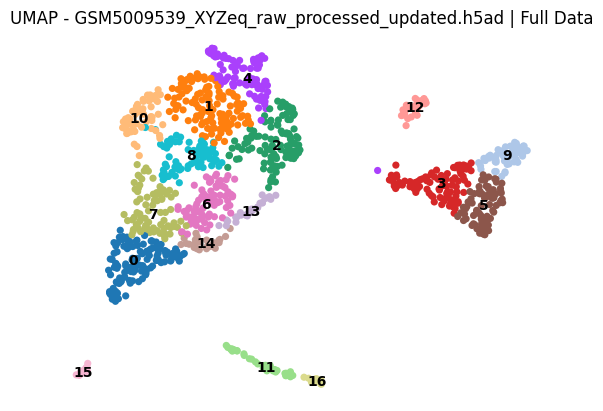

Clustering Run 5...


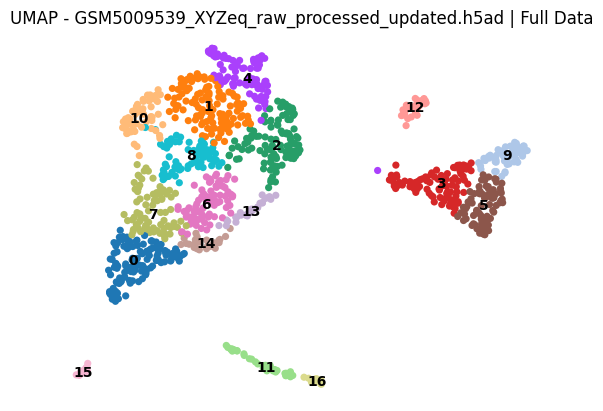

performing clustering on the knn imputation..

Clustering Run 1...


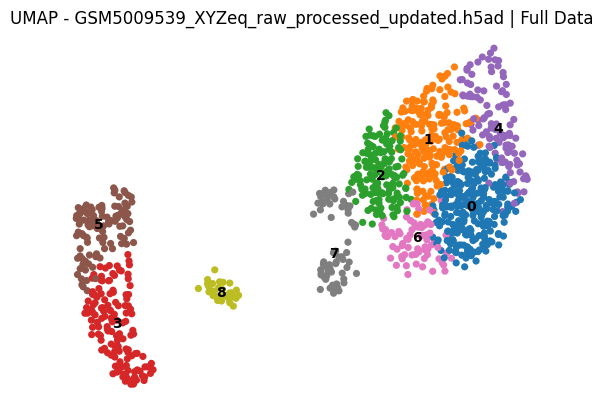

Clustering Run 2...


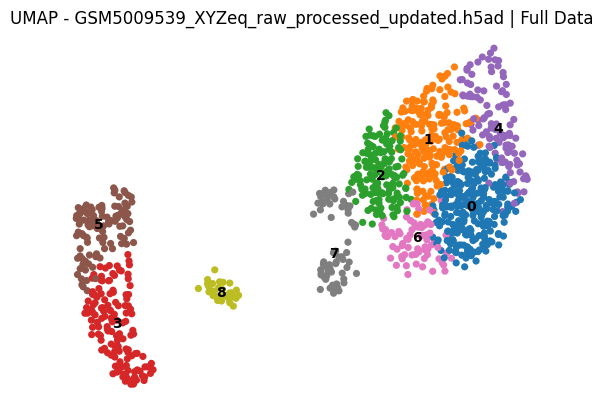

Clustering Run 3...


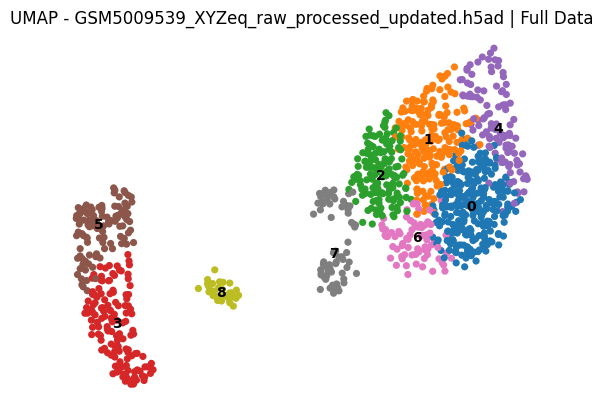

Clustering Run 4...


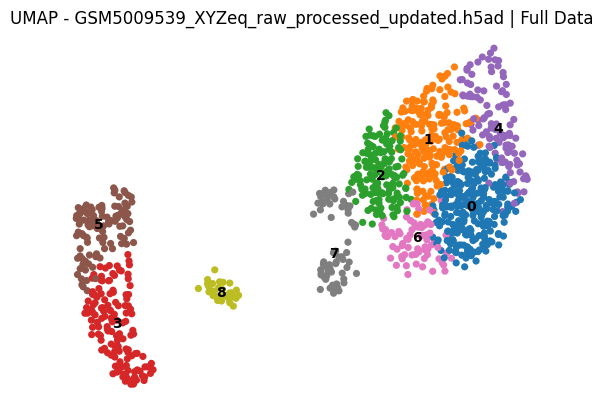

Clustering Run 5...


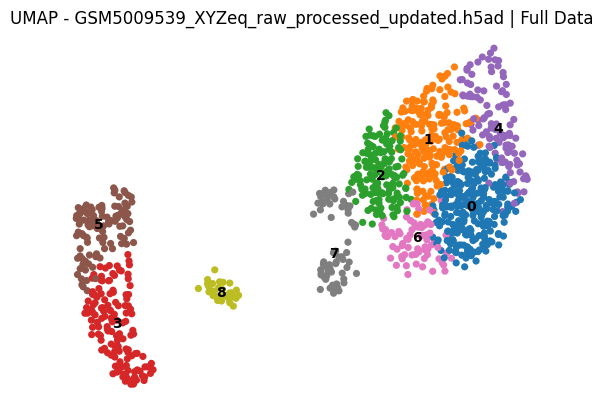

c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


performing clustering on the softimpute imputation..

Clustering Run 1...


C:\Users\fahim\AppData\Local\Temp\ipykernel_23268\3761332667.py:134: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=cluster_key, directed=False, n_iterations=2)


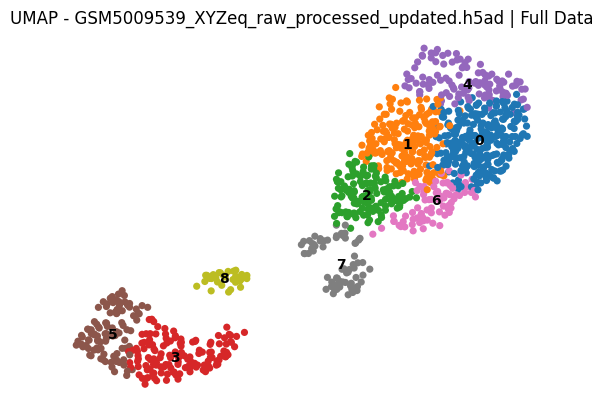

Clustering Run 2...


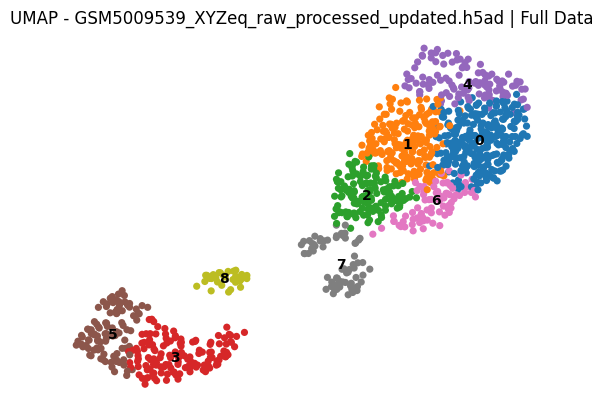

Clustering Run 3...


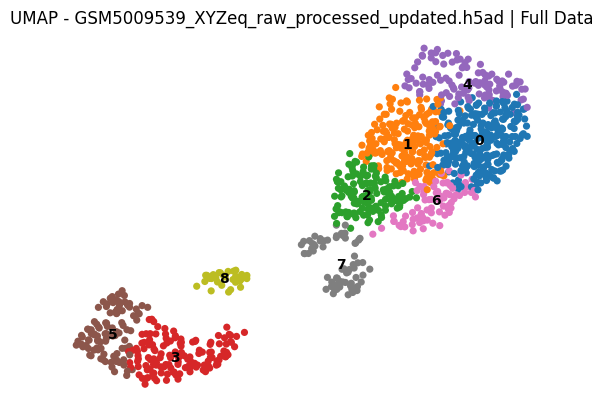

Clustering Run 4...


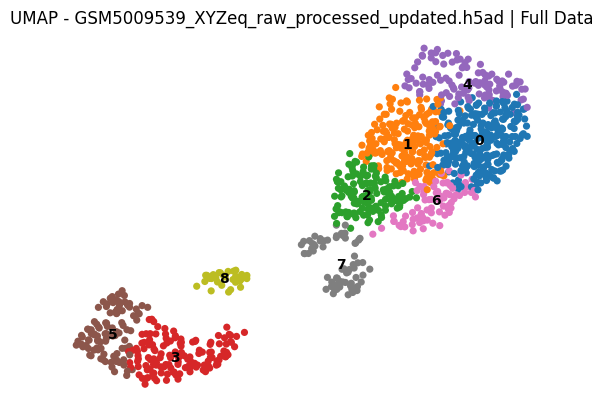

Clustering Run 5...


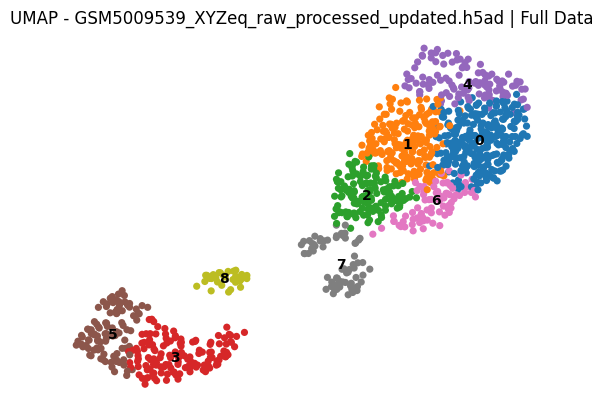

performing clustering on the simpleimpute imputation..

Clustering Run 1...


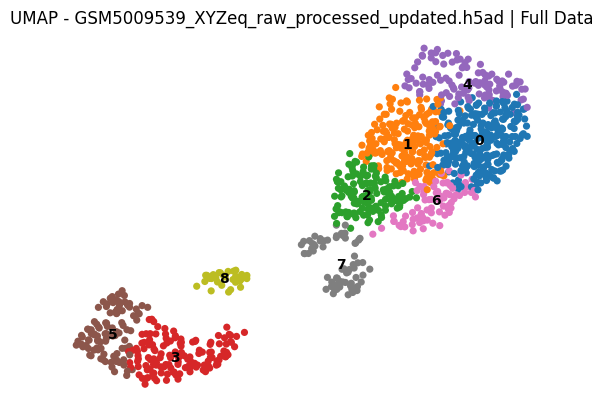

Clustering Run 2...


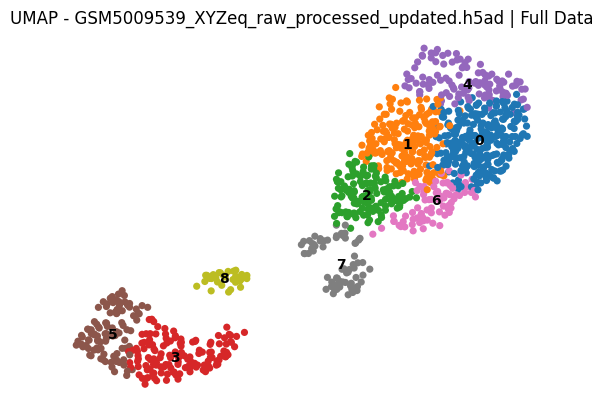

Clustering Run 3...


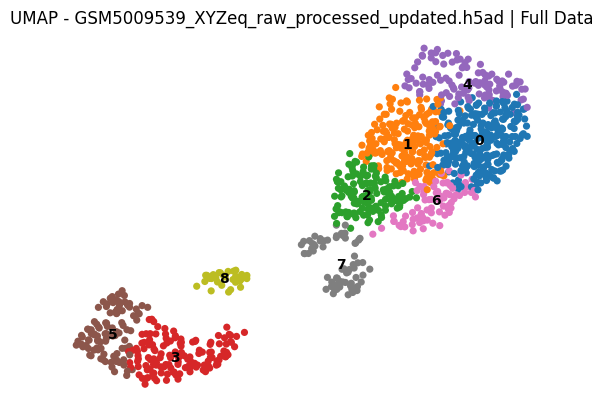

Clustering Run 4...


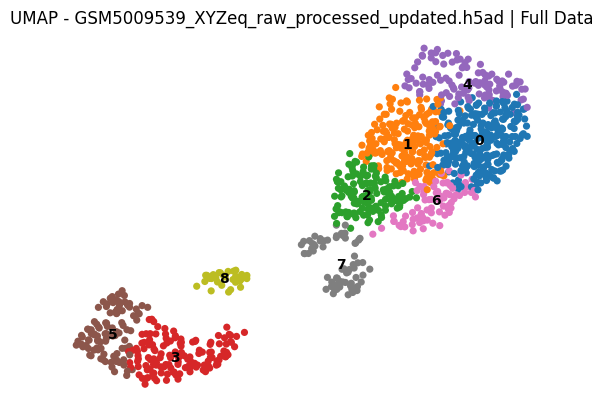

Clustering Run 5...


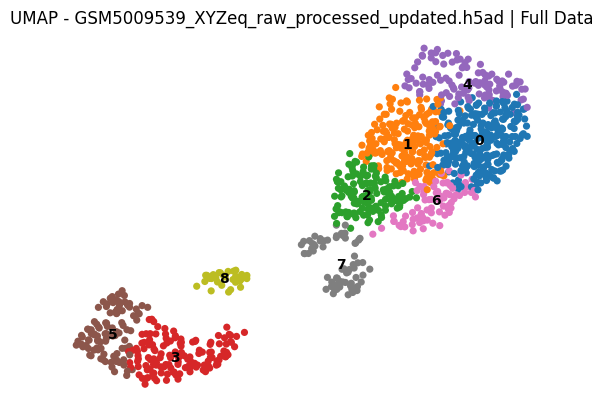

c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


🔍 Analyzing dataset GSM5009539_XYZeq_raw_processed_updated.h5ad for top genes 2000

Loading dataset: D:/VM Data/thesis/Analysis/xyzeq/GSM5009539_XYZeq_raw_processed_updated.h5ad
In the Imputation Evaluator the n_top_genes: 2000


Original adata shape: (1121, 9421)
top genes the class got: 2000

type of this var: <class 'int'>

Adata shape after selecting top 2000 genes: (1121, 2000)
performing baseline clustering..

Base Clustering Run 1...


c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\scanpy\preprocessing\_pca\__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


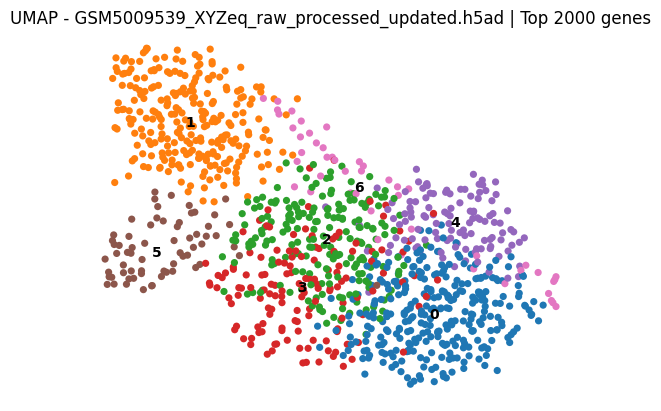

Base Clustering Run 2...


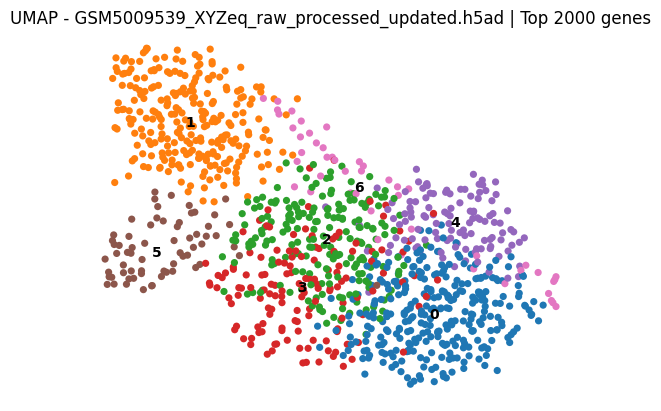

Base Clustering Run 3...


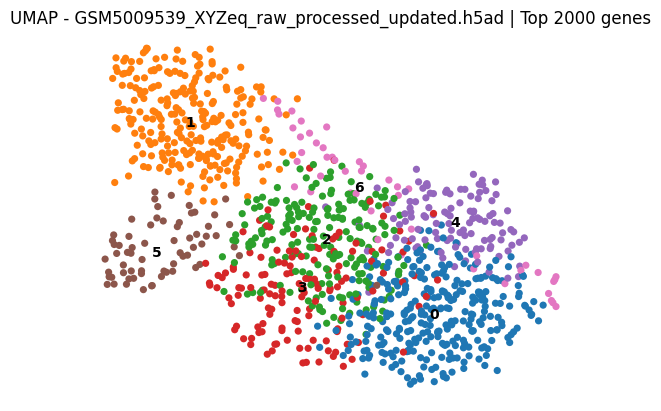

Base Clustering Run 4...


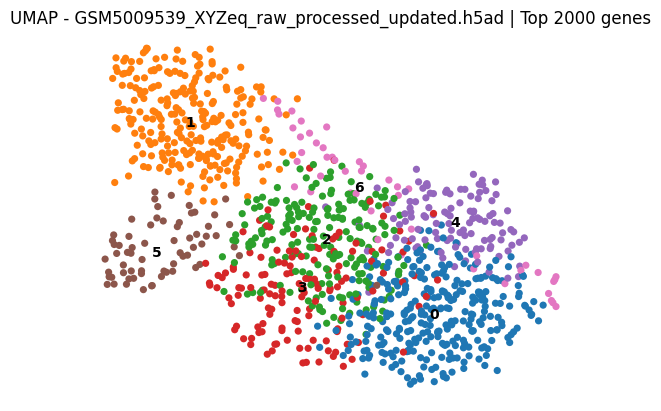

Base Clustering Run 5...


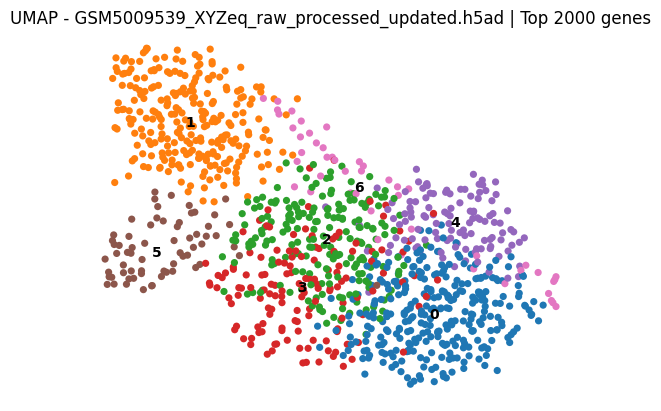

Calculating MAGIC...
  Running MAGIC on 1121 cells and 2000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\magic\magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\magic\magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\magic\magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):


    Calculated PCA in 0.28 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.11 seconds.
    Calculating affinities...
    Calculated affinities in 0.13 seconds.
  Calculated graph and diffusion operator in 0.54 seconds.
  Calculating imputation...
  Calculated imputation in 0.09 seconds.
Calculated MAGIC in 0.63 seconds.
performing clustering on the magic imputation..

Clustering Run 1...


c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\magic\magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):


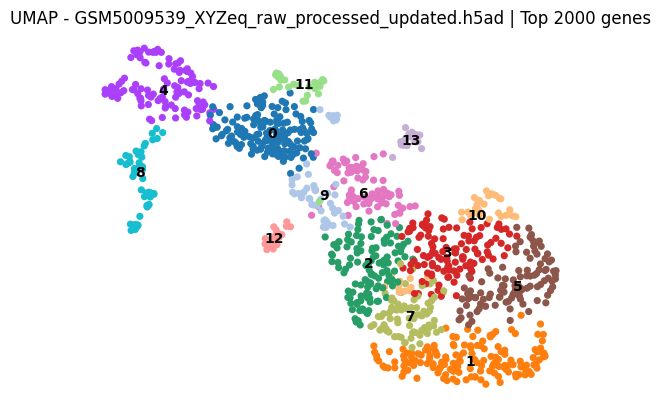

Clustering Run 2...


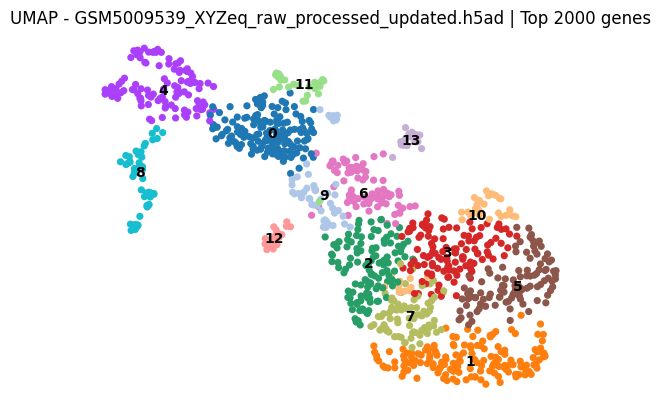

Clustering Run 3...


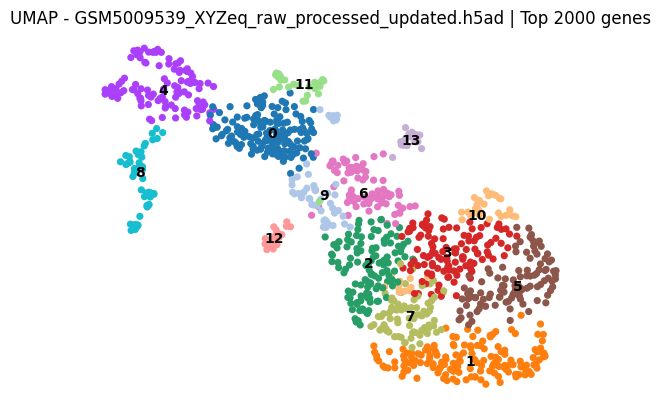

Clustering Run 4...


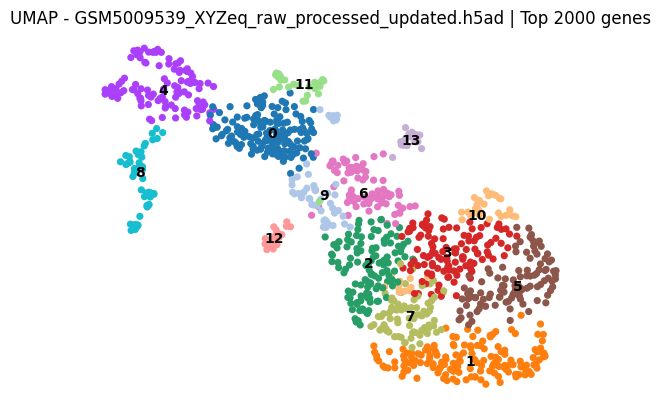

Clustering Run 5...


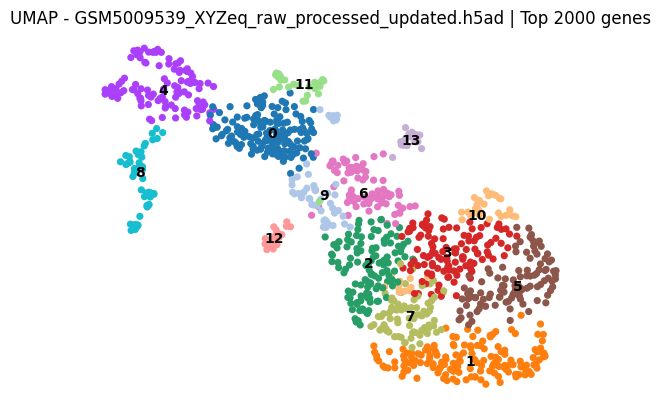

performing clustering on the knn imputation..

Clustering Run 1...


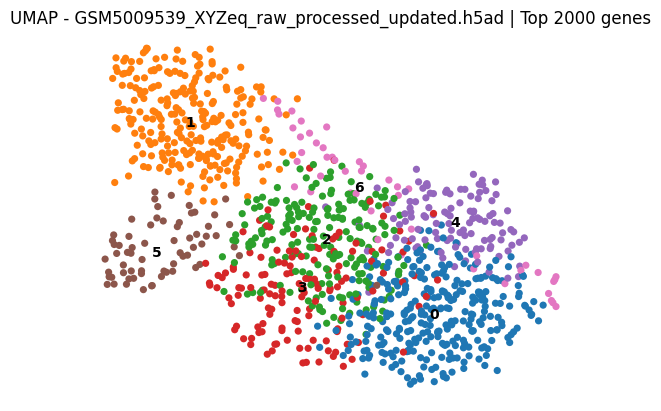

Clustering Run 2...


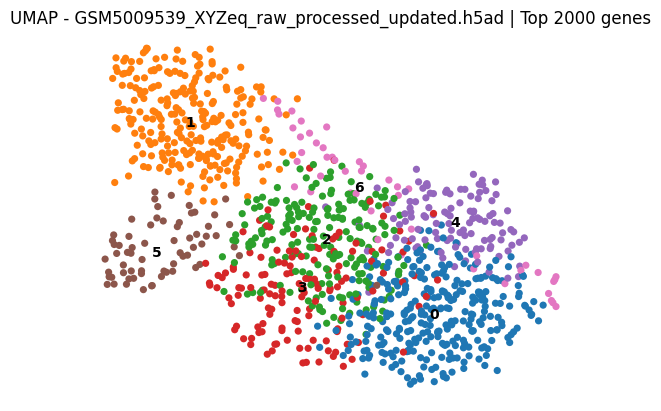

Clustering Run 3...


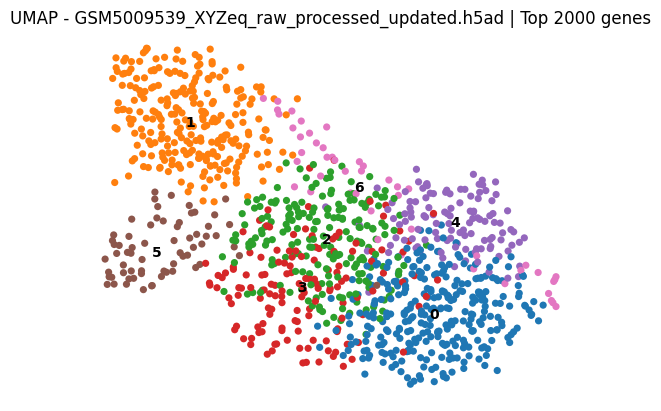

Clustering Run 4...


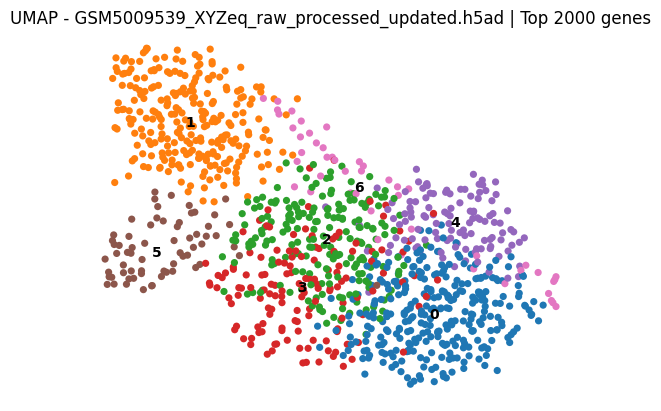

Clustering Run 5...


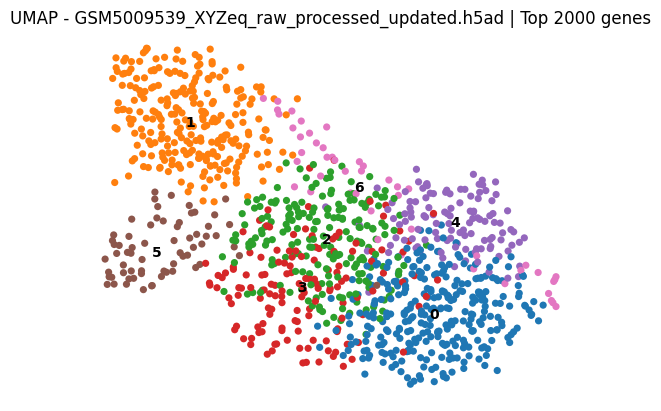

c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


performing clustering on the softimpute imputation..

Clustering Run 1...


C:\Users\fahim\AppData\Local\Temp\ipykernel_23268\3761332667.py:134: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=cluster_key, directed=False, n_iterations=2)


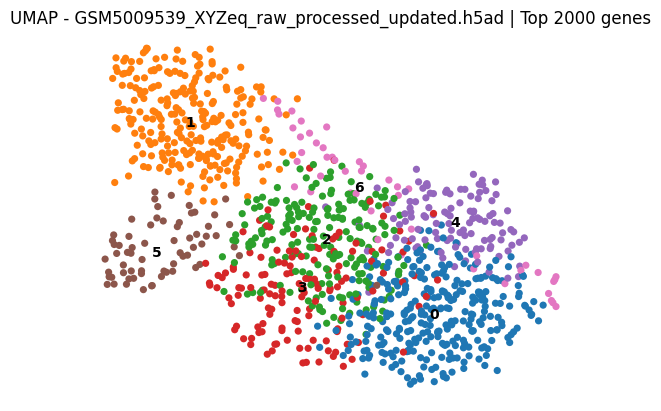

Clustering Run 2...


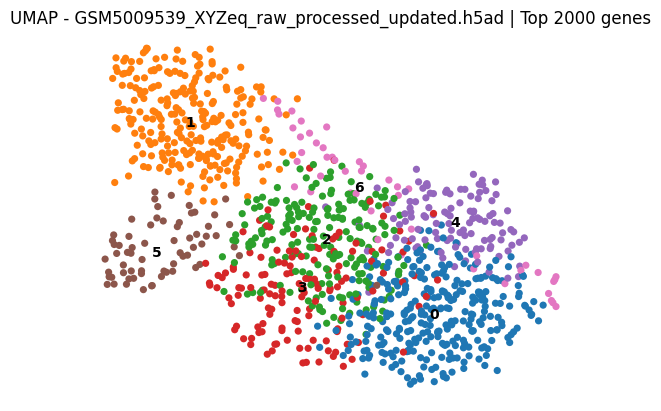

Clustering Run 3...


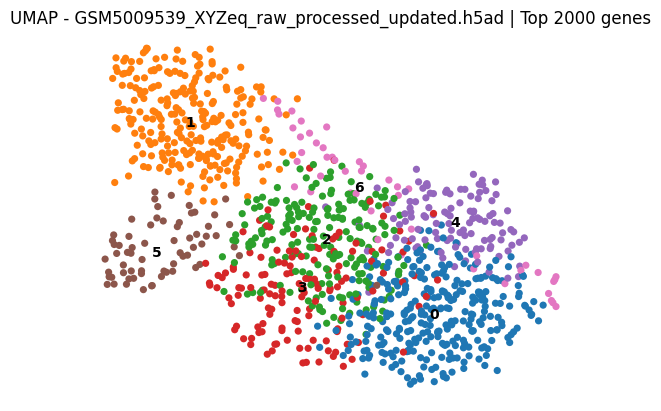

Clustering Run 4...


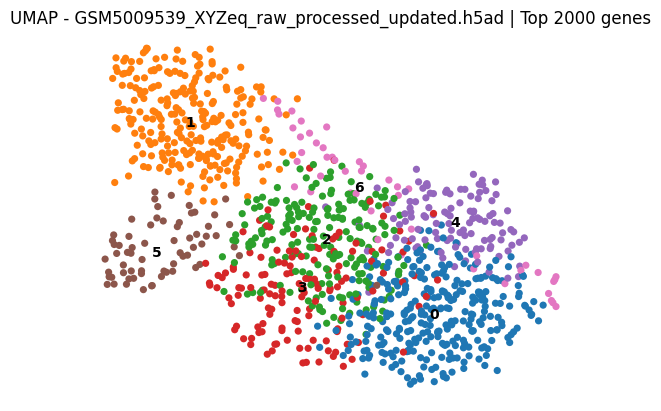

Clustering Run 5...


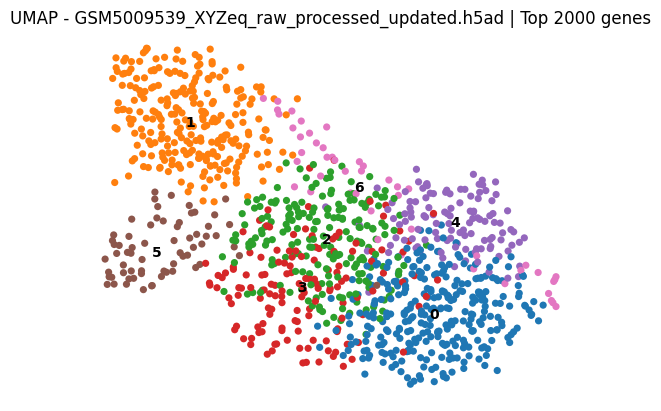

performing clustering on the simpleimpute imputation..

Clustering Run 1...


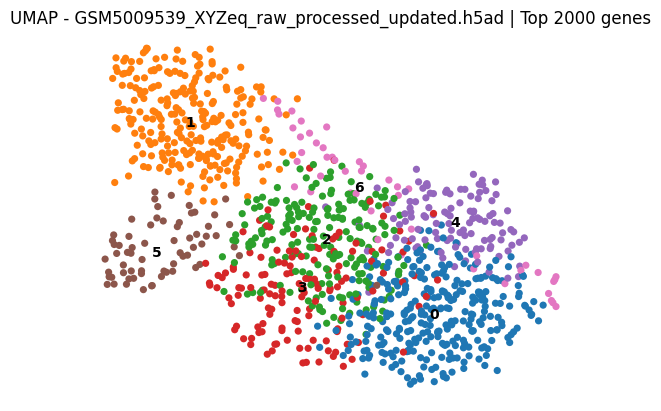

Clustering Run 2...


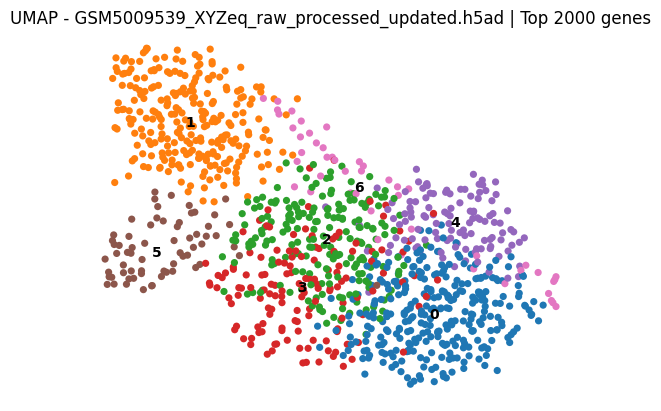

Clustering Run 3...


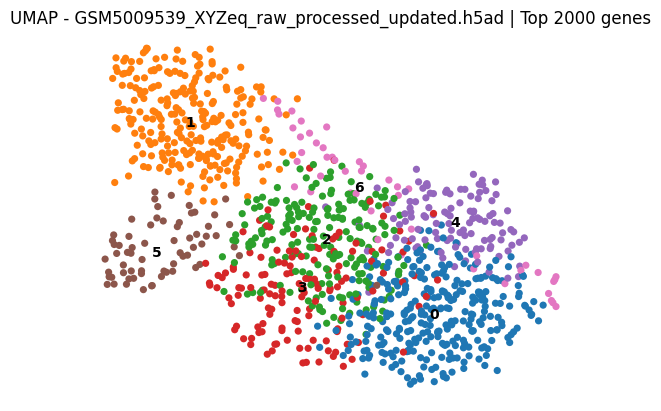

Clustering Run 4...


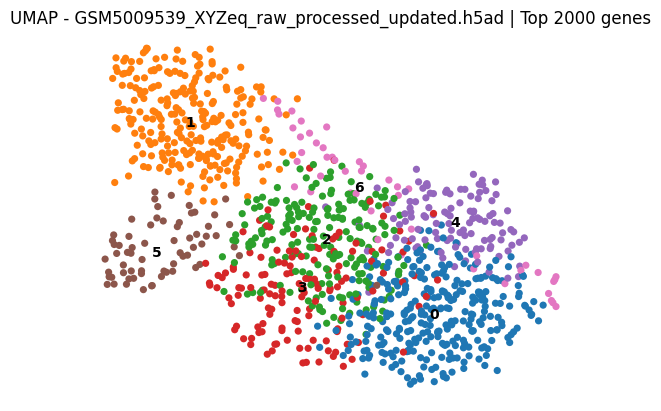

Clustering Run 5...


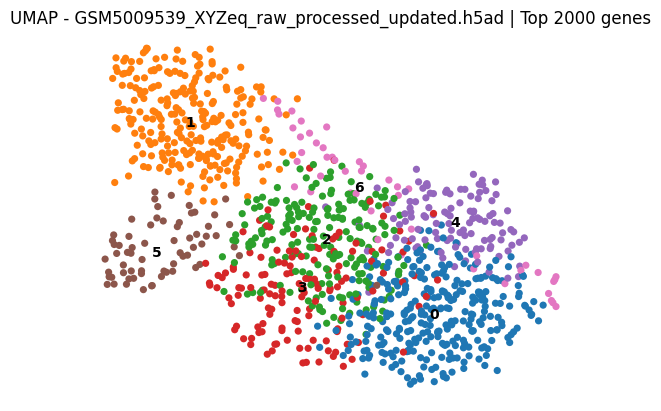

🔍 Analyzing dataset GSM5009539_XYZeq_raw_processed_updated.h5ad for top genes 5000

Loading dataset: D:/VM Data/thesis/Analysis/xyzeq/GSM5009539_XYZeq_raw_processed_updated.h5ad
In the Imputation Evaluator the n_top_genes: 5000


Original adata shape: (1121, 9421)
top genes the class got: 5000

type of this var: <class 'int'>



c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


Adata shape after selecting top 5000 genes: (1121, 5000)
performing baseline clustering..

Base Clustering Run 1...


c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\scanpy\preprocessing\_pca\__init__.py:379: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


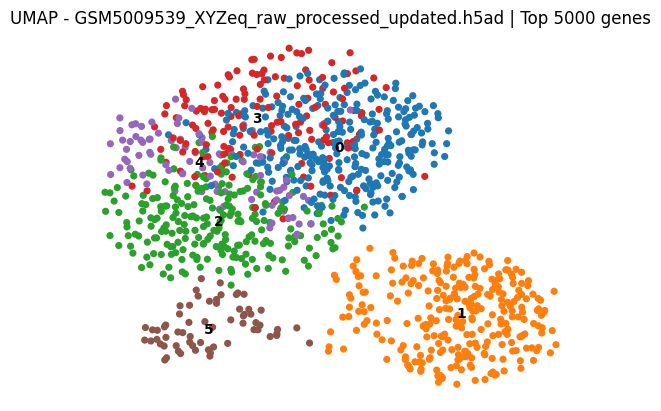

Base Clustering Run 2...


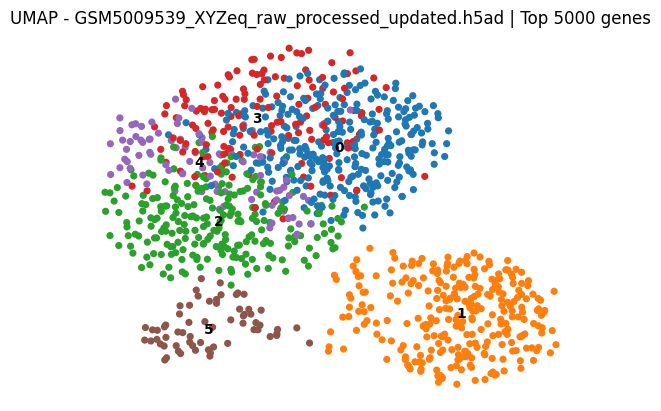

Base Clustering Run 3...


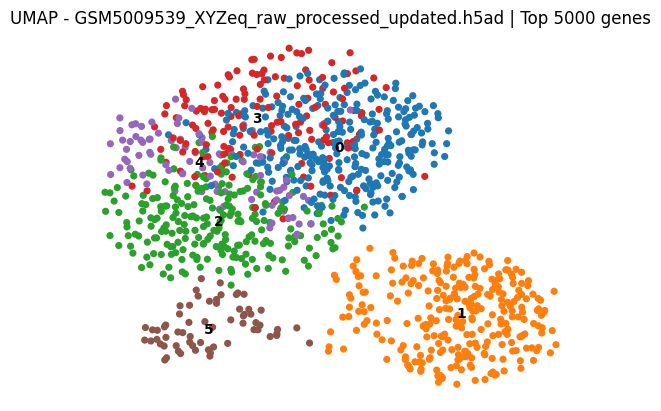

Base Clustering Run 4...


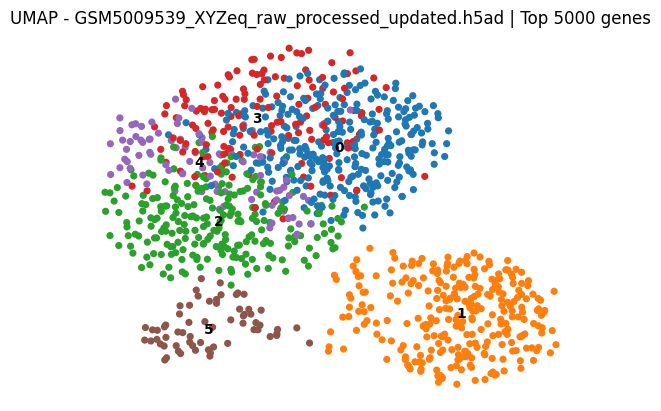

Base Clustering Run 5...


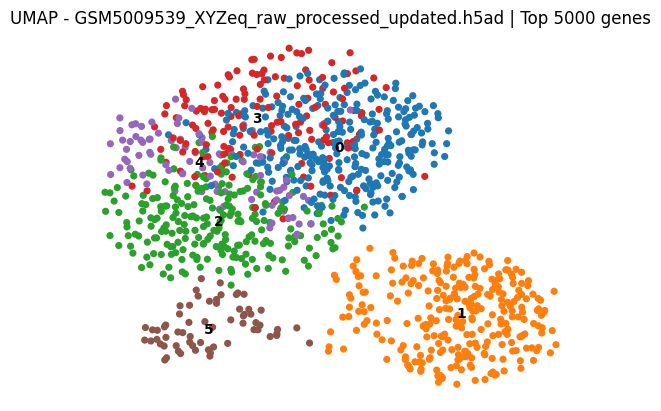

Calculating MAGIC...
  Running MAGIC on 1121 cells and 5000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\magic\magic.py:650: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("MAGIC"):
c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\magic\magic.py:381: DeprecationWarning: Call to deprecated method info. (Use TaskLogger.log_info instead) -- Deprecated since version 1.1.0.
  _logger.info(
c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\magic\magic.py:436: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("graph and diffusion operator"):


    Calculated PCA in 0.55 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.12 seconds.
    Calculating affinities...
    Calculated affinities in 0.12 seconds.
  Calculated graph and diffusion operator in 0.81 seconds.
  Calculating imputation...


c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\magic\magic.py:748: DeprecationWarning: Call to deprecated method task. (Use TaskLogger.log_task instead) -- Deprecated since version 1.1.0.
  with _logger.task("imputation"):


  Calculated imputation in 0.21 seconds.
Calculated MAGIC in 1.05 seconds.
performing clustering on the magic imputation..

Clustering Run 1...


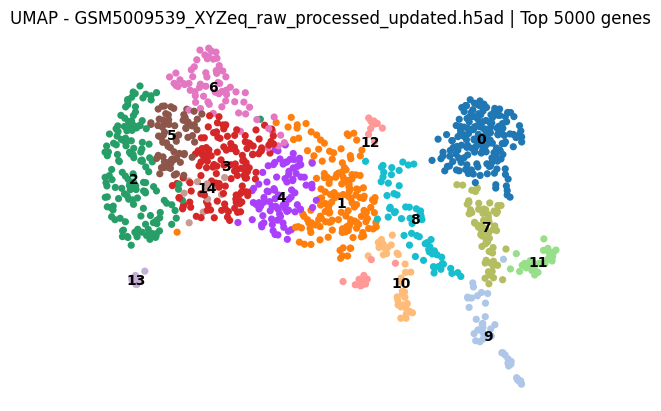

Clustering Run 2...


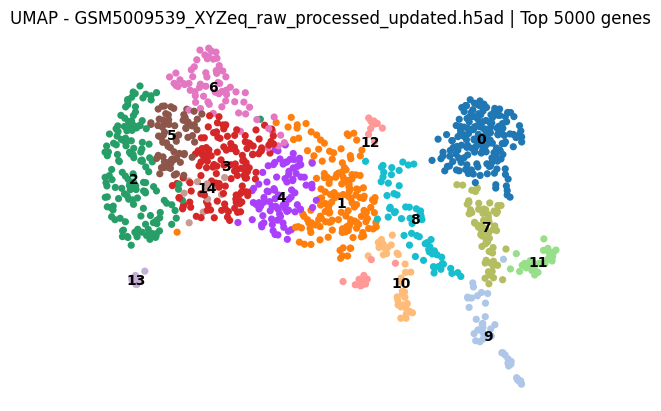

Clustering Run 3...


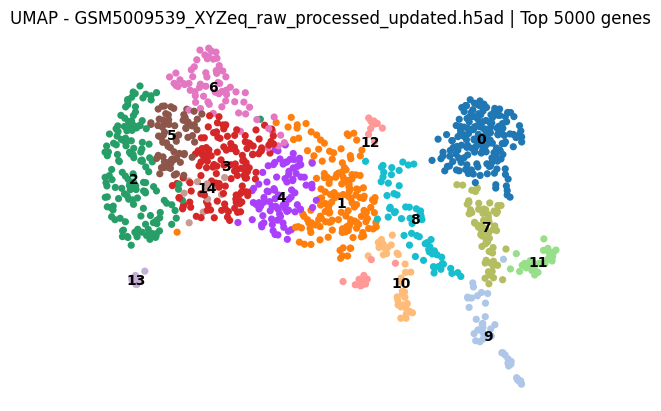

Clustering Run 4...


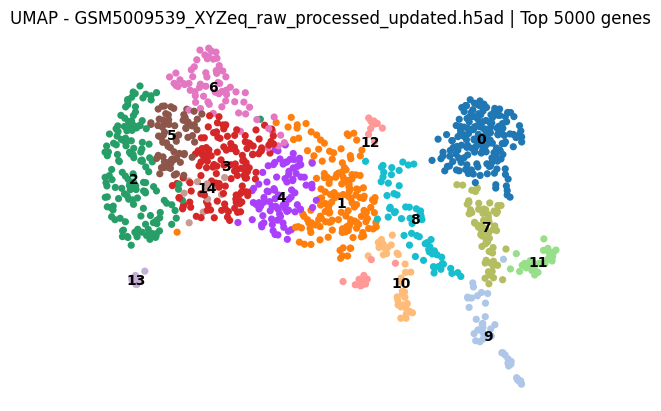

Clustering Run 5...


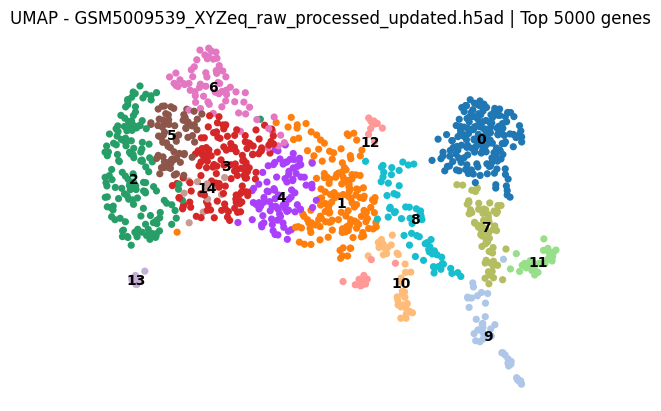

performing clustering on the knn imputation..

Clustering Run 1...


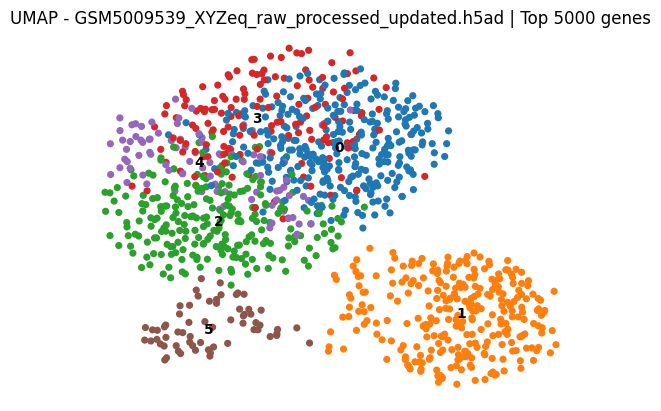

Clustering Run 2...


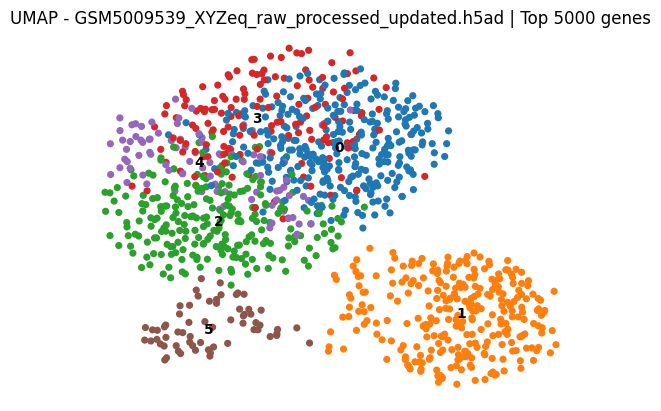

Clustering Run 3...


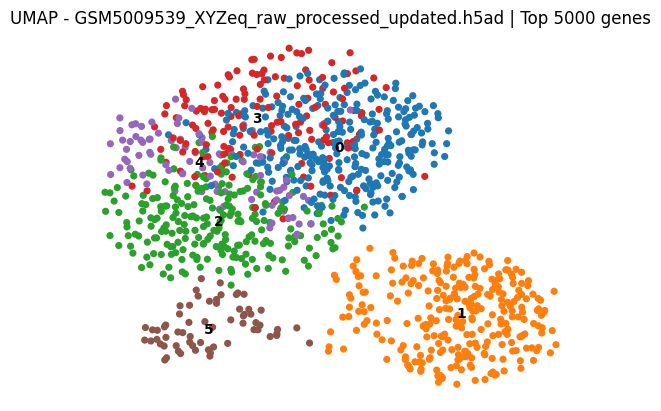

Clustering Run 4...


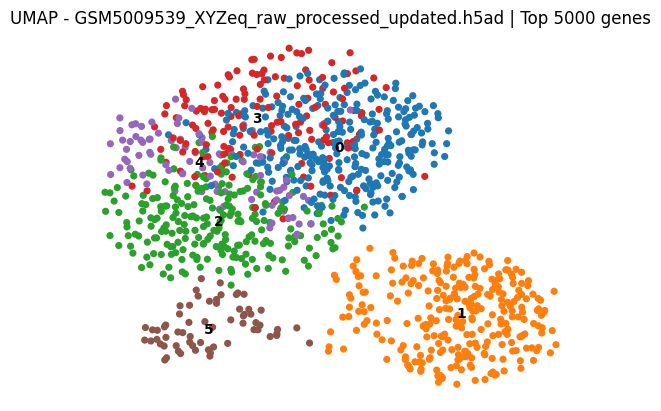

Clustering Run 5...


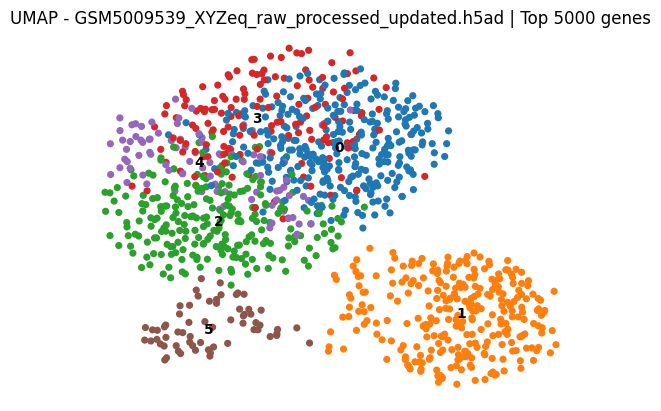

c:\Users\fahim\.conda\envs\GraphST\lib\site-packages\fancyimpute\solver.py:55: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


performing clustering on the softimpute imputation..

Clustering Run 1...


C:\Users\fahim\AppData\Local\Temp\ipykernel_23268\3761332667.py:134: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=cluster_key, directed=False, n_iterations=2)


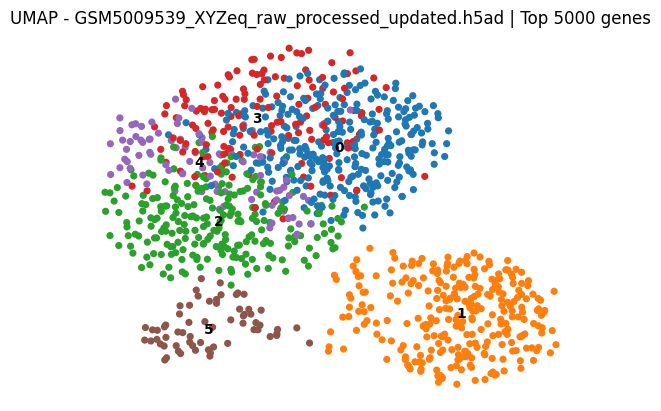

Clustering Run 2...


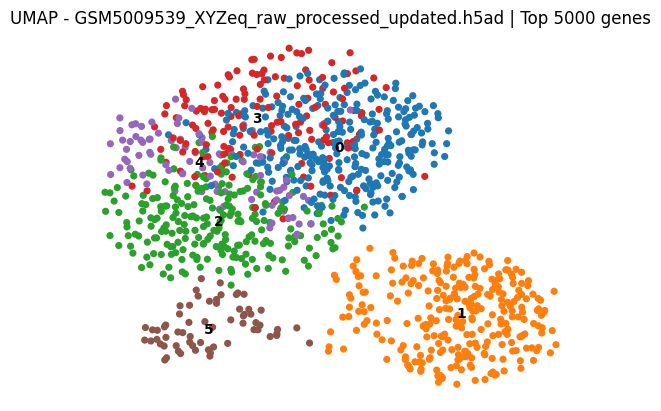

Clustering Run 3...


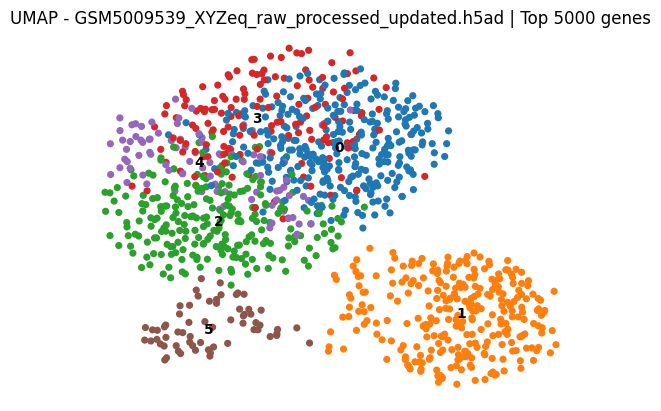

Clustering Run 4...


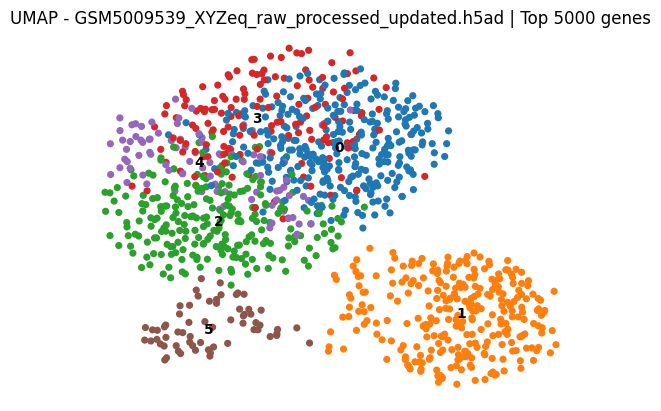

Clustering Run 5...


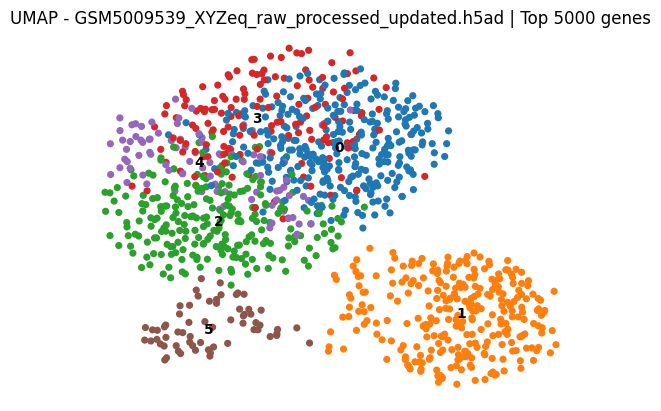

performing clustering on the simpleimpute imputation..

Clustering Run 1...


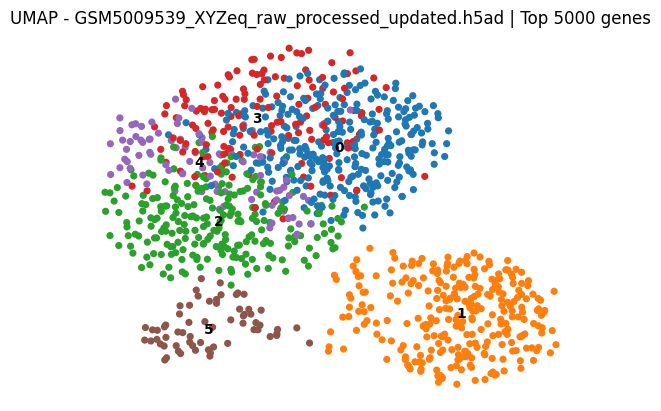

Clustering Run 2...


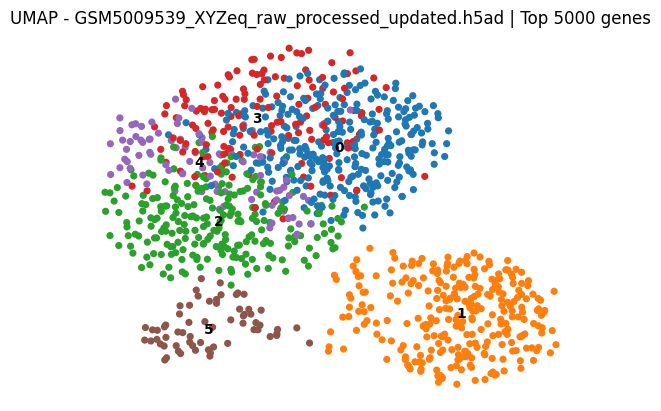

Clustering Run 3...


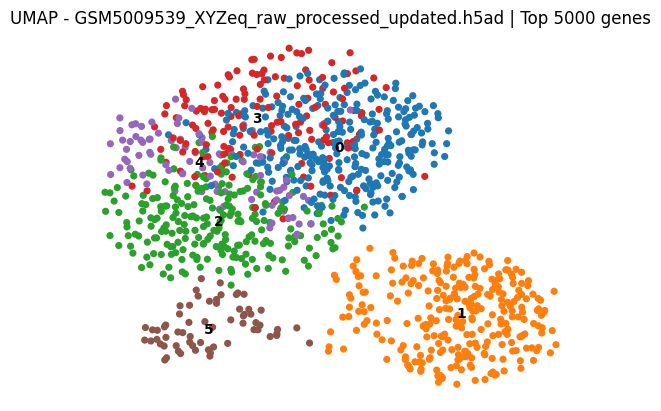

Clustering Run 4...


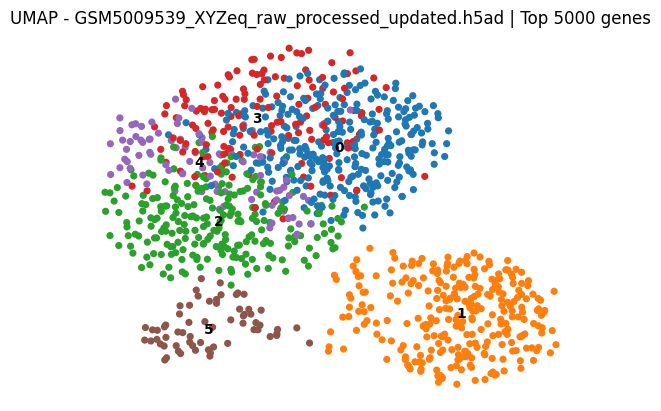

Clustering Run 5...


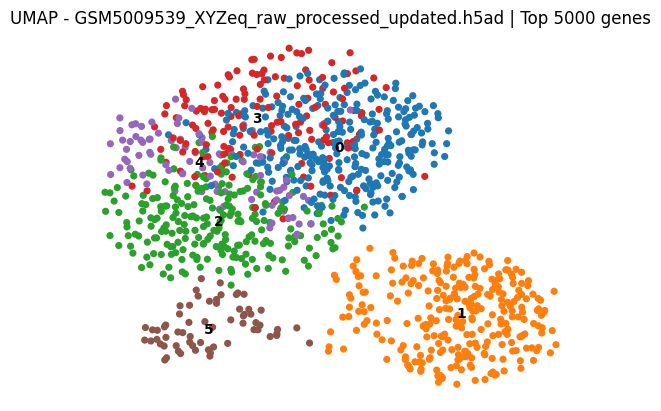

Processing Datasets in Batch-mode: 100%|██████████| 1/1 [04:21<00:00, 261.97s/it]

✅ Results saved for GSM5009539_XYZeq_raw_processed_updated.h5ad

🔄 Remaining datasets and top_genes still to process:


In [ ]:
# @title main function to run in Multi-batch Mode

if __name__ == "__main__":

    dataset_folder = 'D:/VM Data/thesis/Analysis/xyzeq/'
    output_csv = os.path.join(dataset_folder, "xyzeq_magic_knn_soft_simple_imputation_results.csv")

    all_n_top = ['all', 2000, 5000]
    batch_size = 1            # Number of datasets per batch
    n_top_batch_size = 3     # Number of top_genes values per dataset per batch

    all_datasets = sorted([f for f in os.listdir(dataset_folder) if f.endswith('.h5ad')])

    # Load already processed entries
    processed_map = {}
    if os.path.exists(output_csv):
        df_done = pd.read_csv(output_csv)
        for dataset in df_done['Dataset Name'].unique():
            processed_tops = set(df_done[df_done['Dataset Name'] == dataset]['top_genes'].astype(str))
            processed_map[dataset] = processed_tops
    else:
        df_done = pd.DataFrame()
        processed_map = {}

    # Build dictionary of work to be done
    work_dict = {}
    for fname in all_datasets:
        dataset_name = fname
        done_tops = processed_map.get(dataset_name, set())
        remaining_tops = [str(t) for t in all_n_top if str(t) not in done_tops]
        if remaining_tops:
            work_dict[dataset_name] = remaining_tops

    # Print all pending work
    if not work_dict:
        print("✅ All datasets and top_genes combinations are already processed.\n")
    else:
        print(f"🟡 {len(work_dict)} datasets still need processing:")
        for k, v in work_dict.items():
            print(f"  🔸 {k}: Missing top_genes → {v}")
        print()

    # Select datasets to process
    selected_datasets = list(work_dict.keys())[:batch_size]

    for dataset_filename in tqdm(selected_datasets, desc="Processing Datasets in Batch-mode"):
        dataset_path = os.path.join(dataset_folder, dataset_filename)
        remaining_tops = work_dict[dataset_filename]

        # Handle smaller-than-batch case safely
        top_genes_list = remaining_tops[:n_top_batch_size] if len(remaining_tops) >= n_top_batch_size else remaining_tops

        all_results = []
        for n in top_genes_list:
            print(f"🔍 Analyzing dataset {dataset_filename} for top genes {n}")
            df_row = run_on_single_dataset(dataset_path, n_top_genes=n)
            all_results.append(df_row)

        if all_results:
            final_df = pd.concat(all_results, ignore_index=True)
            final_df = final_df.sort_values(by=["Dataset Name", "top_genes"]).reset_index(drop=True)
            df_results_reordered = reorder_columns(final_df)

            if os.path.exists(output_csv):
                df_results_reordered.to_csv(output_csv, mode='a', header=False, index=False)

                # Reload entire CSV and sort
                full_df = pd.read_csv(output_csv)
                full_df = full_df.sort_values(by=["Dataset Name", "top_genes"]).reset_index(drop=True)
                full_df = reorder_columns(full_df)
                full_df.to_csv(output_csv, index=False)

            else:
                df_results_reordered.to_csv(output_csv, index=False)

            print(f"✅ Results saved for {dataset_filename}\n")

    # 🔁 Print remaining work again after processing
    print("🔄 Remaining datasets and top_genes still to process:")
    updated_processed = set()
    if os.path.exists(output_csv):
        updated_df = pd.read_csv(output_csv)
        updated_processed_map = {
            dataset: set(updated_df[updated_df['Dataset Name'] == dataset]['top_genes'].astype(str))
            for dataset in updated_df['Dataset Name'].unique()
        }
        for fname in all_datasets:
            done_tops = updated_processed_map.get(fname, set())
            still_pending = [str(t) for t in all_n_top if str(t) not in done_tops]
            if still_pending:
                print(f"  🔸 {fname}: Missing top_genes → {still_pending}")
    else:
        print("⚠ CSV not found after run, no updates made.")
